In [1]:
# Fix root path
import sys
sys.path.append('..')

In [2]:
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from art.attacks.evasion import BasicIterativeMethod, FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from defences.region_based_classifier import RegionBasedClassifier
from defences.util import dataset2tensor, get_correct_examples, merge_and_generate_labels, get_roc
from defences.baard import ApplicabilityStage, ReliabilityStage, DecidabilityStage, BAARDOperator, flatten

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cuda
CPU threads: 24


In [5]:
PATH_DATA = os.path.join('..', 'data')
PATH_RESULTS = os.path.join('..', 'results', 'mnist_base_model.pt')
BATCH_SIZE = 128
EPOCHS = 20
N_ADV = 2000

In [6]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH_DATA, train=False, download=True, transform=transforms)

# From PyTorch dataset to Numpy array
tensor_X_train, tensor_y_train = dataset2tensor(dataset_train)
X_train = tensor_X_train.cpu().detach().numpy()
y_train = tensor_y_train.cpu().detach().numpy()
tensor_X_test, tensor_y_test = dataset2tensor(dataset_test)
X_test = tensor_X_test.cpu().detach().numpy()
y_test = tensor_y_test.cpu().detach().numpy()

# Split model training set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5000)
dataset_train = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long))

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Check sizes
print(X_train.shape, X_val.shape, X_test.shape)

(55000, 1, 28, 28) (5000, 1, 28, 28) (10000, 1, 28, 28)


## Train point-based classifier

In [8]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(9216, 200)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(200, 10)
        self.softmax = nn.Softmax(dim=1)

    def before_softmax(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.before_softmax(x)
        x = self.softmax(x)
        return x

In [9]:
# Create Neural Network model
model = BaseModel()
model.to(device)
print('Number of layers: {}'.format(len(list(model.children()))))

Number of layers: 10


In [10]:
def train(model, loader, loss, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        outputs = model(x)
        l = loss(outputs, y)
        l.backward()
        optimizer.step()

        # for display
        total_loss += l.item() * batch_size
        preds = outputs.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [11]:
def validate(model, loader, loss, device=device):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            outputs = model(x)
            l = loss(outputs, y)
            total_loss += l.item() * batch_size
            preds = outputs.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [12]:
def predict(model, X, batch_size=BATCH_SIZE, device=device):
    model.eval()
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    tensor_pred = -torch.ones(len(X), dtype=torch.long)
    
    start = 0
    with torch.no_grad():
        for x in loader:
            x = x[0].to(device)
            n = x.size(0)
            end = start + n
            outputs = model(x)
            tensor_pred[start:end] = outputs.max(1)[1].type(torch.long)
            start += n

    return tensor_pred

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.CrossEntropyLoss()

In [14]:
# Load model from saved file
PATH_RESULTS = os.path.join('..', 'results', 'mnist_200.pt')
model.load_state_dict(torch.load(PATH_RESULTS))
_, acc_test = validate(model, dataloader_test, loss)
print('Test set accuracy: {:.4f}'.format(acc_test*100))

Test set accuracy: 98.5200


## Remove missclassified samples

In [15]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss)
print('Accuracy on {} filtered training examples: {:.4f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss)
print('Accuracy on {} filtered test examples: {:.4f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 55000
Accuracy on 54843 filtered training examples: 100.0000%
Test set: 10000
Accuracy on 9852 filtered test examples: 100.0000%


## Load adversarial examples 

In [16]:
classifier = PyTorchClassifier(
    model=model, 
    loss=loss, 
    input_shape=(1, 28, 28), 
    optimizer=optimizer,
    nb_classes=10,
    clip_values=(0.0, 1.0),
    device_type=device
)

In [17]:
X_adv = np.load(os.path.join('..', 'results', 'mnist_basic_apgd_0.3_adv.npy'))
X_benign = np.load(os.path.join('..', 'results', 'mnist_basic_apgd_0.3_x.npy'))
y_true = np.load(os.path.join('..', 'results', 'mnist_basic_apgd_0.3_y.npy'))

In [18]:
pred_benign = np.argmax(classifier.predict(X_benign), axis=1)
accuracy = np.sum(pred_benign == y_true) / float(len(pred_benign))
print("Model accuracy on clean examples: {:.4f}%".format(accuracy * 100))

pred_adv = np.argmax(classifier.predict(X_adv), axis=1)
accuracy = np.sum(pred_adv == y_true) / float(len(pred_adv))
print("Model accuracy on adversarial examples: {:.4f}%".format(accuracy * 100))

Model accuracy on clean examples: 100.0000%
Model accuracy on adversarial examples: 0.0000%


## BAARD

## Applicability Stage

In [19]:
# Use the 2nd half 1000 samples for testing
X_val, labels_val = merge_and_generate_labels(X_adv[1000:], X_benign[1000:])
pred_val = np.concatenate((pred_adv[1000:], y_true[1000:]))

X_test, labels_test = merge_and_generate_labels(X_adv[:1000], X_benign[:1000])
pred_test = np.concatenate((pred_adv[:1000], y_true[:1000]))

### Testing MNIST

In [20]:
stage1 = ApplicabilityStage(quantile=0.9999)
stage1.fit(X_train, y_train)

In [21]:
# Validation set
len(np.where(stage1.predict(X_adv[1000:], pred_adv[1000:]))[0]) / len(X_adv[1000:])

Applicability: 100%|██████████| 10/10 [00:00<00:00, 7119.85it/s]


1.0

In [22]:
np.sum(stage1.predict(X_adv[:1000], pred_adv[:1000])) / len(X_adv[:1000])

Applicability: 100%|██████████| 10/10 [00:00<00:00, 6909.89it/s]


1.0

In [23]:
np.sum(stage1.predict(X_benign[:1000], y_true[:1000])) / 1000

Applicability: 100%|██████████| 10/10 [00:00<00:00, 7609.40it/s]


0.015

In [24]:
stage1.score(X_test, pred_test, labels_test)

Applicability: 100%|██████████| 10/10 [00:00<00:00, 4113.27it/s]


0.9925

## Reliability Stage

In [25]:
stage2 = ReliabilityStage(n_classes=10, k=10, quantile=0.95)

In [26]:
stage2.fit(X_train, y_train)

In [27]:
stage2.search_thresholds(X_val, pred_val, labels_val)

Reliability: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


In [28]:
stage2.thresholds_

array([6.4446845, 3.365222 , 7.0812764, 6.4475117, 6.4566207, 7.27607  ,
       6.491796 , 6.219231 , 7.598177 , 6.150276 ], dtype=float32)

In [29]:
np.sum(stage2.predict(X_adv[1000:], pred_adv[1000:])) / 1000

Reliability: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


0.747

In [30]:
np.sum(stage2.predict(X_adv[:1000], pred_adv[:1000])) / 1000

Reliability: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


0.764

In [31]:
np.sum(stage2.predict(X_benign[:1000], pred_benign[:1000])) / 1000

Reliability: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


0.04

In [32]:
stage2.score(X_test, pred_test, labels_test)

Reliability: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


0.988882

Reliability: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


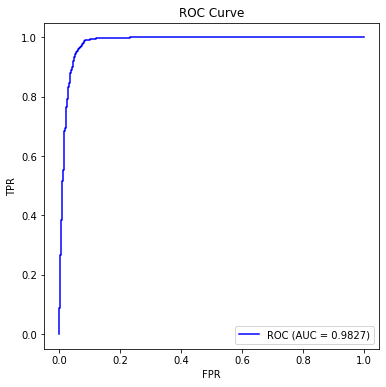

In [42]:
# On validation set
probs = stage2.predict_proba(X_val, pred_val)
_, _, auc_score, _ = get_roc(labels_val, probs, show_plot=True)

Reliability: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


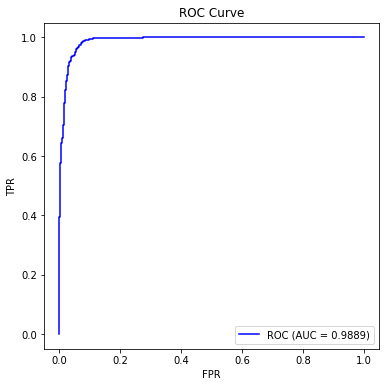

In [36]:
# On test set
probs = stage2.predict_proba(X_test, pred_test)
_, _, auc_score, _ = get_roc(labels_test, probs, show_plot=True)

## Testing Decidability Stage

In [37]:
k = 100
stage3 = DecidabilityStage(n_classes=10, k=k, quantile=0.90)

In [38]:
stage3.fit(X_train, y_train)

In [39]:
stage3.search_thresholds(X_val, pred_val, labels_val)

Decidability: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


In [40]:
stage3.thresholds_

array([0.94 , 1.   , 0.326, 0.61 , 0.546, 0.42 , 0.742, 0.351, 0.301,
       0.62 ], dtype=float32)

In [41]:
np.sum(stage3.predict(X_adv[:1000], pred_adv[:1000])) / 1000

Decidability: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


0.848

In [43]:
np.sum(stage3.predict(X_benign[:1000], y_true[:1000])) / 1000

Decidability: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


0.093

In [44]:
score = stage3.score(X_test, pred_test, labels_test)
score

0.9534914999999999

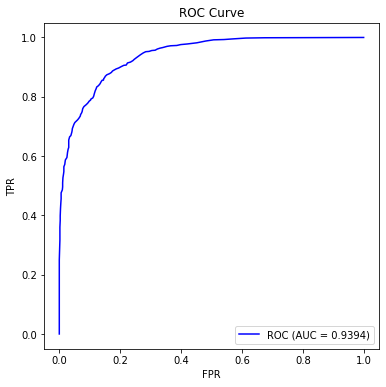

In [45]:
probs = stage3.predict_proba(X_val, pred_val)
_, _, auc_score, _ = get_roc(labels_val, probs, show_plot=True)

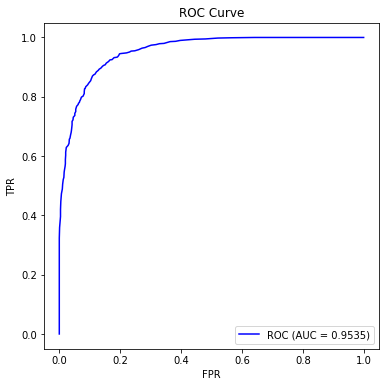

In [46]:
# On test set
probs = stage3.predict_proba(X_test, pred_test)
_, _, auc_score, _ = get_roc(labels_test, probs, show_plot=True)

## Testing BAARD Operator

In [47]:
stages = []
stages.append(ApplicabilityStage(n_classes=10, quantile=0.999))
stages.append(ReliabilityStage(n_classes=10, k=10, quantile=0.95))
stages.append(DecidabilityStage(n_classes=10, k=100, quantile=0.95))

baard = BAARDOperator(stages=stages)

In [48]:
print(X_train.shape, y_train.shape)

(55000, 1, 28, 28) (55000,)


In [49]:
baard.fit(X_train, y_train)

In [50]:
print(X_val.shape, pred_val.shape, labels_val.shape)

(2000, 784) (2000,) (2000,)


In [51]:
baard.search_thresholds(X_val, pred_val, labels_val)

Decidability: 100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


In [54]:
results = baard.detect(X_adv[:1000], pred_adv[:1000])

Applicability: 100%|██████████| 10/10 [00:00<00:00, 8272.79it/s]


In [55]:
print(np.sum(results))

1000


In [56]:
results = baard.detect(X_benign[:1000], y_true[:1000])

Decidability: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


In [57]:
print(np.sum(results))

100
